# Simple Classifier Experiments

In [62]:
import pandas as pd
import numpy as np
import click
from matplotlib import pyplot as plt
import posture_detector as pst
from posture_detector.utils.constants import columns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import RidgeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, LeavePOut


# Load Data

In [2]:
df = pd.read_csv(
    '../data/raw/datalog_at_2021-03-05_23_21_38.953248',
    sep=';'
)
df = pst.data.parse_dataset(df)
df.head()


,Ax,Ay,Az,T,Gx,Gy,Gz,FlS,Label
0,-0.10,0.74,0.46,31.92,-2.95,-0.02,1.41,580,nan
1,-0.11,0.75,0.45,31.92,-3.18,-0.45,0.18,580,nan
2,-0.10,0.74,0.46,31.97,-2.82,0.94,3.11,580,nan
3,-0.11,0.75,0.47,31.92,-3.44,1.47,3.82,579,nan
4,-0.10,0.75,0.46,31.97,-2.46,1.31,4.37,579,nan


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2186 entries, 0 to 2185
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ax      2186 non-null   float64
 1   Ay      2186 non-null   float64
 2   Az      2186 non-null   float64
 3   T       2186 non-null   float64
 4   Gx      2186 non-null   float64
 5   Gy      2186 non-null   float64
 6   Gz      2186 non-null   float64
 7   FlS     2186 non-null   int64  
 8   Label   2186 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 153.8+ KB


In [4]:
df['Label'].unique()

array(['nan', 'Key.enter', 'a', 'c', 'g'], dtype=object)

In [5]:
df.head()

,Ax,Ay,Az,T,Gx,Gy,Gz,FlS,Label
0,-0.10,0.74,0.46,31.92,-2.95,-0.02,1.41,580,nan
1,-0.11,0.75,0.45,31.92,-3.18,-0.45,0.18,580,nan
2,-0.10,0.74,0.46,31.97,-2.82,0.94,3.11,580,nan
3,-0.11,0.75,0.47,31.92,-3.44,1.47,3.82,579,nan
4,-0.10,0.75,0.46,31.97,-2.46,1.31,4.37,579,nan


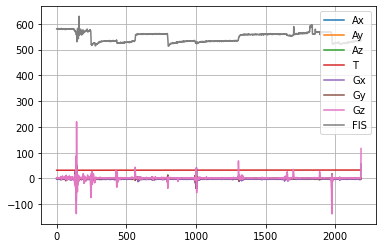

In [6]:
df.plot()
plt.grid()
plt.show()

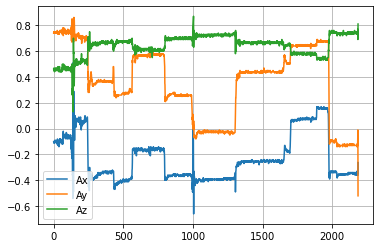

In [7]:
df[['Ax', 'Ay', 'Az']].plot()
plt.grid()
plt.show()

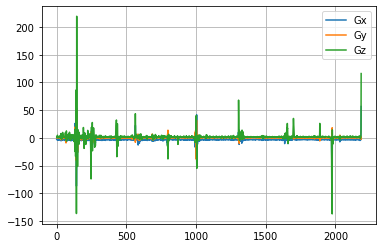

In [8]:
df[['Gx', 'Gy', 'Gz']].plot()
plt.grid()
plt.show()

In [9]:
slice_dropna = ~df['Label'].apply( lambda x: x == 'nan')
slice_with_labels = ~df['Label'].apply( lambda x: x == 'Key.enter')
slice_with_postures = ~df['Label'].apply( lambda x: x not in ['a', 'c'])
data = df[ slice_dropna & slice_with_labels & slice_with_postures ].copy()
data['Label'].unique()

array(['a', 'c'], dtype=object)

In [10]:
data.head()

,Ax,Ay,Az,T,Gx,Gy,Gz,FlS,Label
116,-0.07,0.76,0.45,32.11,-4.17,1.76,0.08,580,a
117,-0.07,0.76,0.46,32.11,-2.33,-0.39,4.32,581,a
118,-0.05,0.74,0.47,32.06,-1.80,0.07,2.17,580,a
119,-0.06,0.76,0.47,31.97,-3.79,0.41,-1.61,580,a
120,-0.06,0.75,0.45,32.01,-2.21,-0.50,2.05,581,a


In [11]:
encoding = LabelEncoder()
data['Label'] = encoding.fit_transform(data['Label'])
data['Label'].unique()

<ipython-input-11-5c9fefef266d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Label'] = encoding.fit_transform(data['Label'])


array([0, 1])

In [13]:
X = data.drop('Label', axis=1)
y = data['Label']

# Modelling

## Train and Evaluate Model


In [26]:
def print_model_score(m, X=X, y=y):
    scores = cross_val_score(
        m,
        X, y,
        cv=10,
        n_jobs=6,
        scoring='accuracy'
    )
    print(f'{scores.mean():.2f} +- {np.std(scores):.2f}')

In [27]:
print_model_score(RidgeClassifier())

0.89 +- 0.09


In [60]:
print_model_score(DecisionTreeClassifier())

0.76 +- 0.21


In [64]:
print_model_score(ExtraTreeClassifier())

0.75 +- 0.23


In [63]:
print_model_score(RandomForestClassifier())

0.79 +- 0.23


In [28]:
print_model_score(
    RidgeClassifier(),
    X.drop('FlS', axis=1), y
)

0.85 +- 0.12


In [ ]:
print_model_score(
    RidgeClassifier(),
    X['FlS'].values.reshape(-1, 1), y
)

In [68]:
print_model_score(
    RidgeClassifier(),
    X[['Ay', 'FlS']], y
)

0.88 +- 0.09


In [ ]:
gyro = ['Ax', 'Ay', 'Az']
for axis in gyro:
    print(axis, end=None)
    print_model_score(
        RidgeClassifier(),
        X[axis].values.reshape(-1, 1), y
    )

In [49]:
ac = ['Gx', 'Gy', 'Gz']
for axis in ac:
    print(axis, end='')
    print_model_score(
        RidgeClassifier(),
        X[axis].values.reshape(-1, 1), y
    )

Gx0.77 +- 0.01
Gy0.77 +- 0.01
Gz0.76 +- 0.00


## Baseline

In [ ]:
print_model_score(
    DummyClassifier(strategy='most_frequent')
)

## PCA Analysis

In [43]:
for n_components in [1, 2, 3]:
    pipeline = Pipeline([
        ('pca', PCA(n_components=n_components)),
        ('model', RidgeClassifier())
    ])

    print(f'PCA with {n_components} components -> ', end='')
    print_model_score(
        pipeline
    )

PCA with 1 components -> 0.78 +- 0.04
PCA with 2 components -> 0.88 +- 0.09
PCA with 3 components -> 0.88 +- 0.09
